<a href="https://colab.research.google.com/github/sanchitgulati/ML-notebooks/blob/main/car_example_tensor_flow_estimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
plt.style.use("seaborn-colorblind")
%matplotlib inline

# Data


In [109]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [110]:
import os
path = '/content/drive/MyDrive/ml-notebooks/airbnb'
os.chdir(path)

In [111]:
# Provide the names for the columns since the CSV file with the data does
# not have a header row.
feature_names = ['symboling', 'normalized-losses', 'make', 'fuel-type',
        'aspiration', 'num-doors', 'body-style', 'drive-wheels',
        'engine-location', 'wheel-base', 'length', 'width', 'height', 'weight',
        'engine-type', 'num-cylinders', 'engine-size', 'fuel-system', 'bore',
        'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
        'highway-mpg', 'price']


# Load in the data from a CSV file that is comma separated.
car_data = pd.read_csv('https://storage.googleapis.com/mledu-datasets/cars_data.csv',
                        sep=',', names=feature_names, header=None, encoding='latin-1')


# We'll then randomize the data, just to be sure not to get any pathological
# ordering effects that might harm the performance of Stochastic Gradient
# Descent.
car_data = car_data.reindex(np.random.permutation(car_data.index))

print("Data set loaded. Num examples: ", len(car_data))

Data set loaded. Num examples:  205


# Clean Up

In [112]:
LABEL = 'price'
numeric_feature_names = ['symboling','normalized-losses','wheel-base','length','width',
                         'height','weight','engine-size','bore','stroke',
                         'compression-ratio','horsepower','peak-rpm','city-mpg','highway-mpg']
categorical_feature_names = list(set(feature_names) - set(numeric_feature_names) - set([LABEL]))

In [113]:
for feature in numeric_feature_names + [LABEL]:
  car_data[feature] = car_data[feature].replace('?', np.NaN)
  car_data[feature] = car_data[feature].astype(float)
  car_data[feature].fillna(car_data[feature].median(),inplace = True)
for feature in categorical_feature_names:
  print(feature,car_data[feature].mode().iloc[0])
  car_data[feature] = car_data[feature].replace('?', np.NaN)
  car_data[feature].fillna(car_data[feature].mode().iloc[0],inplace = True)

fuel-system mpfi
num-doors four
fuel-type gas
make toyota
body-style sedan
drive-wheels fwd
num-cylinders four
aspiration std
engine-location front
engine-type ohc


# Visualizing Price

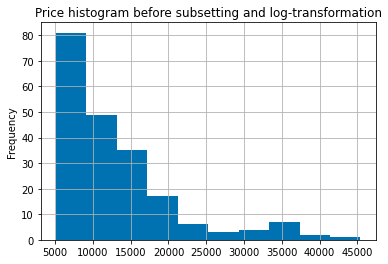

In [114]:
car_data['price'].plot(kind = 'hist',grid = True)
plt.title("Price histogram before subsetting and log-transformation");

In [115]:
car_data['price'].skew() # not much skewed

1.8409793088634676

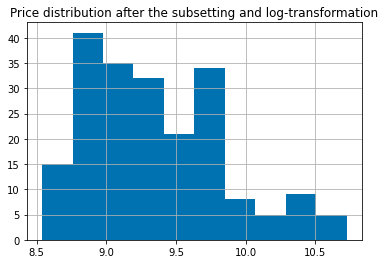

In [116]:
target = np.log(car_data.price)
target.hist()
plt.title("Price distribution after the subsetting and log-transformation");

# Feature Selection

In [117]:
# default = plt.rcParams["figure.figsize"]
# plt.rcParams["figure.figsize"] = (30,10)
# car_data[numeric_feature_names].corr().plot()
# plt.rcParams["figure.figsize"] = default

In [118]:
car_data[numeric_feature_names].corr()

,symboling,normalized-losses,wheel-base,length,width,height,weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg
symboling,1.000000,0.457484,-0.531954,-0.357612,-0.232919,-0.541038,-0.227691,-0.105790,-0.132563,-0.004928,-0.178515,0.071064,0.273851,-0.035823,0.034606
normalized-losses,0.457484,1.000000,-0.073709,-0.006837,0.058378,-0.365674,0.064343,0.072536,-0.050428,0.046739,-0.114772,0.166964,0.241134,-0.189530,-0.149357
wheel-base,-0.531954,-0.073709,1.000000,0.874587,0.795144,0.589435,0.776386,0.569329,0.489556,0.159684,0.249786,0.352876,-0.361338,-0.470414,-0.544082
length,-0.357612,-0.006837,0.874587,1.000000,0.841118,0.491029,0.877728,0.683360,0.607016,0.128622,0.158414,0.553337,-0.286362,-0.670909,-0.704662
width,-0.232919,0.058378,0.795144,0.841118,1.000000,0.279210,0.867032,0.735433,0.559262,0.182708,0.181129,0.641337,-0.219374,-0.642704,-0.677218
height,-0.541038,-0.365674,0.589435,0.491029,0.279210,1.000000,0.295572,0.067149,0.173506,-0.058994,0.261214,-0.109286,-0.321113,-0.048640,-0.107358
weight,-0.227691,0.064343,0.776386,0.877728,0.867032,0.295572,1.000000,0.850594,0.648848,0.168164,0.151362,0.750927,-0.266358,-0.757414,-0.797465
engine-size,-0.105790,0.072536,0.569329,0.683360,0.735433,0.067149,0.850594,1.000000,0.585636,0.200246,0.028971,0.810216,-0.244383,-0.653658,-0.677470
bore,-0.132563,-0.050428,0.489556,0.607016,0.559262,0.173506,0.648848,0.585636,1.000000,-0.056054,0.005468,0.574258,-0.256600,-0.582627,-0.585352
stroke,-0.004928,0.046739,0.159684,0.128622,0.182708,-0.058994,0.168164,0.200246,-0.056054,1.000000,0.185679,0.083804,-0.059716,-0.044973,-0.046389


In [119]:
# numeric_feature_names = [
# #  'symboling',
# #  'normalized-losses',
#  'wheel-base',
#  'length',
#  'width',
# #  'height',
#  'weight',
#  'engine-size',
#  'bore',
# #  'stroke',
# #  'compression-ratio',
#  'horsepower',
# #  'peak-rpm',
#  'city-mpg',
#  'highway-mpg'
# ]

In [120]:
# categorical_feature_names = [
#  'aspiration',
# #  'engine-type',
# #  'fuel-system',
#  'make',
#  'drive-wheels',
#  'fuel-type',
# #  'num-cylinders',
# #  'num-doors',
#  'body-style',
# #  'engine-location'
#  ]

In [121]:
features = car_data[numeric_feature_names + categorical_feature_names]

# Split the data into train and test set

In [122]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

## Types of featureColumn

### More at https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html

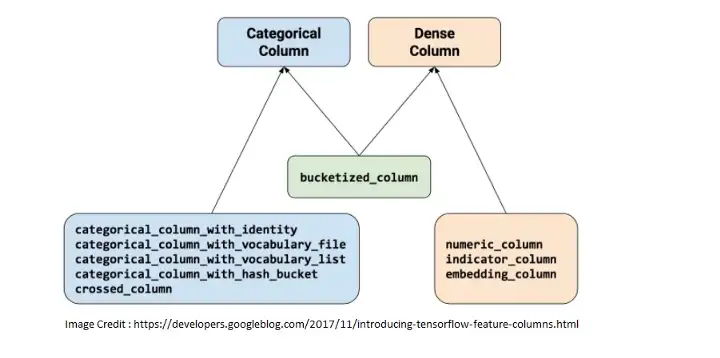

# Making Features

In [123]:
numeric_features = [tf.feature_column.numeric_column(key = column) for column in numeric_feature_names]
numeric_features

[NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='engine-size', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='bore', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='stroke', shape=(1,), default_value=None, dtype=tf.float32, n

In [124]:
categorical_features = [tf.feature_column.categorical_column_with_vocabulary_list(key = column, 
                                                                                 vocabulary_list = features[column].unique()) 
                                                                                for column in categorical_feature_names]
categorical_features

[VocabularyListCategoricalColumn(key='fuel-system', vocabulary_list=('mpfi', 'mfi', '1bbl', '2bbl', 'spdi', 'idi', '4bbl', 'spfi'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='num-doors', vocabulary_list=('two', 'four'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='fuel-type', vocabulary_list=('gas', 'diesel'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='make', vocabulary_list=('toyota', 'dodge', 'honda', 'mazda', 'subaru', 'audi', 'volvo', 'plymouth', 'bmw', 'mercury', 'nissan', 'mitsubishi', 'volkswagen', 'mercedes-benz', 'jaguar', 'alfa-romero', 'porsche', 'renault', 'isuzu', 'peugot', 'saab', 'chevrolet'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='body-style', vocabulary_list=('sedan', 'hatchback', 'wagon', 'convertible', 'hardtop'), dtype=tf.string, default_value=-1, num_oov_buckets=0),


## Numeric plus Categorical Features

In [125]:
features = numeric_features + categorical_features

# Magic

In [126]:
logs = "logs"

In [127]:
%reload_ext tensorboard

In [128]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [129]:
# %tensorboard --logdir logs

In [130]:
batch_size = 16

In [131]:
# Create training input function
training_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(x = X_train,
                                                        y=y_train,
                                                        batch_size=batch_size,
                                                        shuffle= True,
                                                        num_epochs = None)
# create testing input function
eval_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(x=X_test,
                                                    y=y_test,
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    num_epochs = 1)

In [132]:
linear_regressor = tf.estimator.LinearRegressor(feature_columns=features)

## Train

In [133]:
linear_regressor.train(input_fn = training_input_fn,steps=2000)

In [134]:
model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()))
    for feature_name in categorical_feature_names
]
print('model_feature_columns', model_feature_columns)

DNNRegressor = tf.compat.v1.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.compat.v1.train.ProximalAdagradOptimizer(
      learning_rate=0.1,
      # l1_regularization_strength=0.001,
    ))

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  DNNRegressor.train(training_input_fn, steps=num_training_steps // num_print_statements)
  scores = DNNRegressor.evaluate(eval_input_fn)

model_feature_columns [IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='fuel-system', vocabulary_list=('mpfi', 'mfi', '1bbl', '2bbl', 'spdi', 'idi', '4bbl', 'spfi'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='num-doors', vocabulary_list=('two', 'four'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='fuel-type', vocabulary_list=('gas', 'diesel'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='make', vocabulary_list=('toyota', 'dodge', 'honda', 'mazda', 'subaru', 'audi', 'volvo', 'plymouth', 'bmw', 'mercury', 'nissan', 'mitsubishi', 'volkswagen', 'mercedes-benz', 'jaguar', 'alfa-romero', 'porsche', 'renault', 'isuzu', 'peugot', 'saab', 'chevrolet'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(ca

In [135]:
linear_regressor.evaluate(input_fn = eval_input_fn)

{'average_loss': 0.09593267,
 'label/mean': 9.231319,
 'loss': 0.09420201,
 'prediction/mean': 9.26064,
 'global_step': 2000}

In [136]:
metrics = DNNRegressor.evaluate(input_fn=eval_input_fn)

## Predict

In [138]:
X = X_test
Y = y_test

predict_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=X_test,
    batch_size=batch_size,
    shuffle=False)

linear_pred = list(linear_regressor.predict(input_fn = predict_input_fn))
dnn_predictions = list(DNNRegressor.predict(input_fn= predict_input_fn))

pred_linear = [p['predictions'][0] for p in linear_pred]
pred_dnn = [p['predictions'][0] for p in dnn_predictions]

predicted_prices_linear = np.around(np.exp(pred_linear)) # exp it up from log value and round it up
predicted_prices_dnn = np.around(np.exp(pred_dnn)) # exp it up from log value and round it up


original_prices = np.exp(y_test)
results_data = {'ground_truth': original_prices, 'prediction_linear' : predicted_prices_linear, 'diff_linear' : predicted_prices_linear  - original_prices,  'prediction_dnn' : predicted_prices_dnn, 'diff_dnn' : predicted_prices_dnn  - original_prices }
r_df = pd.DataFrame(results_data)
r_df

,ground_truth,prediction_linear,diff_linear,prediction_dnn,diff_dnn
172,17669.0,27956.0,10287.0,13956.0,-3713.0
118,5572.0,6731.0,1159.0,5207.0,-365.0
90,7099.0,7351.0,252.0,8327.0,1228.0
4,17450.0,14421.0,-3029.0,11983.0,-5467.0
95,7799.0,7186.0,-613.0,6630.0,-1169.0
...,...,...,...,...,...
81,8499.0,8182.0,-317.0,5343.0,-3156.0
200,16845.0,26812.0,9967.0,14314.0,-2531.0
112,16900.0,13848.0,-3052.0,14498.0,-2402.0
55,10945.0,12705.0,1760.0,12594.0,1649.0


# Export to Google Sheets

In [139]:
# authenticate

from google.colab import auth
import gspread
from google.auth import default
#autenticating to google
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [140]:
# create, and save df
from gspread_dataframe import set_with_dataframe
title = 'car_example_tensor_flow_estimator'
gc.create(title)  # if not exist
sheet = gc.open(title).sheet1
set_with_dataframe(sheet, r_df,include_index=False, include_column_header=True, resize=False) 
# include_index=False, include_column_header=True, resize=False

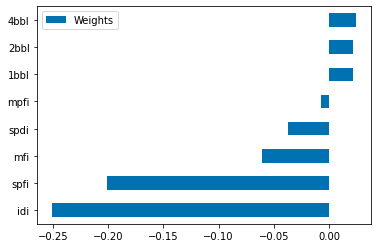

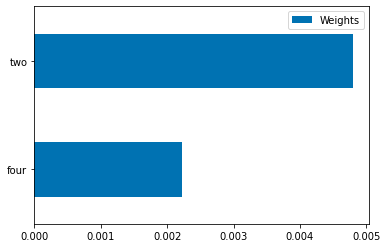

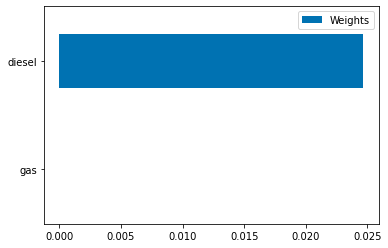

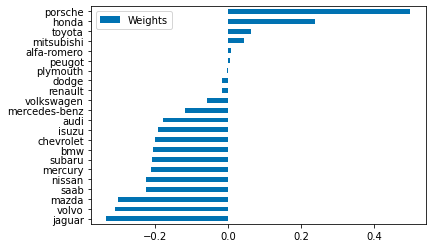

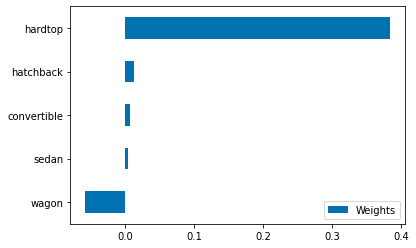

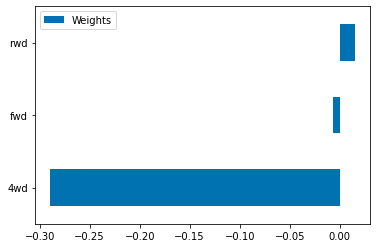

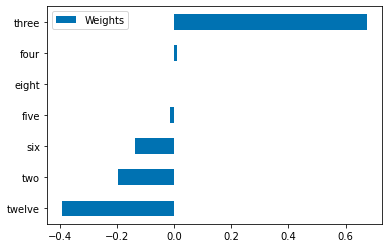

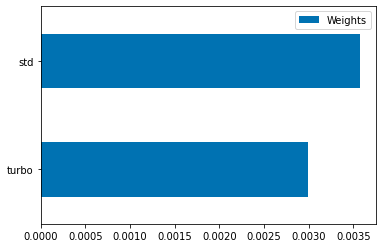

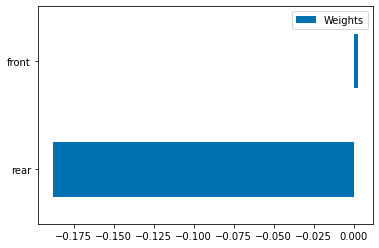

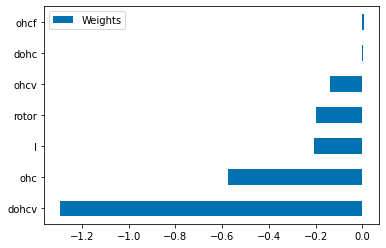

In [141]:
feature_weights_to_plot = categorical_feature_names
# num_cols = 3
# num_rows = int(math.ceil(len(feature_weights_to_plot)/float(num_cols)))
# f, axarr = plt.subplots(num_rows, num_cols)

for i, feature_name in enumerate(feature_weights_to_plot):
  # axis = axarr[int(i/num_cols), i%num_cols]
  property_weights = linear_regressor.get_variable_value('linear/linear_model/{}/weights'.format(feature_name)).flatten()
  property_keys = car_data[feature_name].value_counts().keys()
  f = pd.DataFrame({"Weights":property_weights},index=property_keys).sort_values("Weights",ascending=True).plot(kind='barh');
  # axis.set_ylabel('feature_value')
  # axis.set_xlabel('feature_name')
  # axis.plot(f)
plt.show()